# Restaurant Analysis 🍷

---



## Import some useful stuff

---



In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

## Data overview

---



### Connect to SQLite database


In [ ]:
conn = sqlite3.connect("db.sqlite3")
cursor = conn.cursor()

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = cursor.fetchall()
print("Tables in the database:", tables)

Tables in the database: [('sqlite_sequence',), ('restaurant_orderitem',), ('restaurant_product',), ('restaurant_order',)]


### Exploring table structures

First of all, I want to understand the structure of the tables and identify the key columns in order to proceed with the next step.

In [ ]:
def show_columns(table_name):
    """
    Display the column names and data types for a given SQLite table.
    -----------------------------------------------------------------
    Parameters:
    table_name : str
    The name of the table in the SQLite database.
    -----------------------------------------------------------------
    Returns:
    None
    Prints the name and data type of each column in the specified table.
    """
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    print(f"\n Columns in table '{table_name}':")
    for col in columns:
        print(f" >> {col[1]} ({col[2]})")
        # col[1] — column name, col[2] — type

In [ ]:
for table in ['restaurant_orderitem', 'restaurant_product', 'restaurant_order']:
    show_columns(table)


 Columns in table 'restaurant_orderitem':
 >> id (INTEGER)
 >> quantity (INTEGER)
 >> order_id (bigint)
 >> product_id (bigint)

 Columns in table 'restaurant_product':
 >> id (INTEGER)
 >> price (decimal)
 >> name (varchar(100))

 Columns in table 'restaurant_order':
 >> id (INTEGER)
 >> datetime (datetime)


### Table preview

In [ ]:
def preview_table(table_name, limit = 5):
    """
    Display the first few rows of a given SQLite table.
    ---------------------------------------------------
    Parameters:
    table_name : str
    limit : int, optional (default = 5)
    ---------------------------------------------------
    Returns:
    None
    Prints the first 'limit' rows from the specified table.
    """
    cursor.execute(f"SELECT * FROM {table_name} LIMIT {limit};")
    rows = cursor.fetchall()
    print(f"\n Preview of table '{table_name}':")
    for row in rows:
        print(f" >> {row}")

In [ ]:
for table in ['restaurant_orderitem', 'restaurant_product', 'restaurant_order']:
    preview_table(table)


 Preview of table 'restaurant_orderitem':
 >> (1, 2, 1, 6)
 >> (2, 1, 1, 240)
 >> (3, 1, 1, 19)
 >> (4, 1, 1, 36)
 >> (5, 1, 1, 111)

 Preview of table 'restaurant_product':
 >> (1, 0.5, 'Mint Sauce')
 >> (2, 0.5, 'Lime Pickle')
 >> (3, 0.5, 'Mango Chutney')
 >> (4, 0.5, 'Red Sauce')
 >> (5, 0.5, 'Onion Chutney')

 Preview of table 'restaurant_order':
 >> (1, '2019-08-03 20:25:00')
 >> (2, '2019-08-03 20:17:00')
 >> (3, '2019-08-03 20:09:00')
 >> (4, '2019-08-03 20:01:00')
 >> (5, '2019-08-03 19:44:00')


### Table size check

In [ ]:
def count_rows(table_name):
    """
    Display the total number of rows in a given SQLite table.
    ---------------------------------------------------------
    Parameters:
    table_name : str
    ---------------------------------------------------------
    Returns:
    Prints the total number of rows in the specified table.
    """
    cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
    count = cursor.fetchone()[0]
    print(f"\n The '{table_name}' table has {count} rows.")

In [ ]:
for table in ['restaurant_orderitem', 'restaurant_product', 'restaurant_order']:
    count_rows(table)


 The 'restaurant_orderitem' table has 74818 rows.

 The 'restaurant_product' table has 248 rows.

 The 'restaurant_order' table has 13397 rows.


### Initial Exploration Summary

We created three utility functions to help us understand the structure, size, and preview of each table in our database. From the initial exploration, we found that the largest table, restaurant_orderitem, contains 74,818 rows, representing all individual items sold.

The restaurant_product table includes product names and prices, which likely correspond to the items on the restaurant’s menu.

The restaurant_order table contains datetimes and order IDs. With 13,397 unique orders recorded, we can estimate that each order contains approximately 5.58 items on average.

### Column Descriptions

#### Restaurant order table

| Column Name | Type     | Description                         |
| ----------- | -------- | ----------------------------------- |
| 🔑 id       | int64    | Unique identifier for each order    |
| datetime    | datetime | Timestamp when the order was placed |

#### Restraunt orderitem table

| Column Name    | Type  | Description                                                     |
| -------------- | ----- | --------------------------------------------------------------- |
| 🔑 id          | int64 | Unique identifier for each order item                           |
| quantity       | int64 | Number of product units ordered                                 |
| 🔗 order\_id   | int64 | Foreign key referencing the related order in restaurant_order |
| 🔗 product\_id | int64 | Foreign key referencing the product in restaurant_product     |

#### Restraunt product table

| Column Name | Type             | Description                           |
| ----------- | ---------------- | ------------------------------------- |
| 🔑 id       | int64            | Unique identifier for each product    |
| price       | float (decimal)  | Price of a single unit of the product |
| name        | string (varchar) | Name or description of the product    |


### Simple ER Diagram: Table Connections

The following diagram illustrates how the main orderitem table is connected to the orders and products tables via foreign keys.

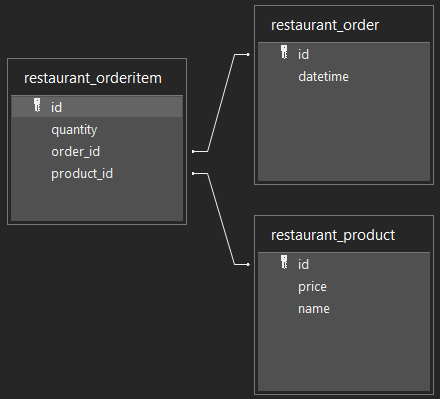

## Creating main dataframe

---

### Joins & Creating csv

To join these tables, we have two main options. We can use a LEFT JOIN if we want to ensure that all order items are included, even if some don’t have matching order timestamps. However, a safer and more typical approach would be to use an INNER JOIN, especially between orderitem and product, since knowing the product names is essential for analysis.

In [ ]:
df = pd.read_sql_query("""
SELECT
    oi.id AS orderitem_id,
    o.datetime,
    p.name AS product_name,
    p.price,
    oi.quantity,
    oi.order_id
FROM restaurant_orderitem oi
JOIN restaurant_product p ON oi.product_id = p.id
LEFT JOIN restaurant_order o ON oi.order_id = o.id
""", conn)

### Build core dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   orderitem_id  74818 non-null  int64  
 1   datetime      74818 non-null  object 
 2   product_name  74818 non-null  object 
 3   price         74818 non-null  float64
 4   quantity      74818 non-null  int64  
 5   order_id      74818 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [ ]:
df.describe()

,orderitem_id,price,quantity,order_id
count,74818.000000,74818.000000,74818.000000,74818.000000
mean,37409.500000,5.267512,1.243564,5756.303563
std,21598.240557,3.325707,0.798207,3745.827156
min,1.000000,0.500000,1.000000,1.000000
25%,18705.250000,2.950000,1.000000,2461.000000
50%,37409.500000,3.950000,1.000000,5308.000000
75%,56113.750000,8.950000,1.000000,8913.000000
max,74818.000000,17.950000,51.000000,13397.000000


In [ ]:
df = df.assign(
        orderitem_id = df["orderitem_id"].astype("uint32"),
        price        = df["price"].astype("float32"),
        quantity     = df["quantity"].astype("uint8"),
        order_id     = df["order_id"].astype("uint16"),
        product_name = df["product_name"].astype("category"),
        datetime     = pd.to_datetime(df["datetime"]) )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   orderitem_id  74818 non-null  uint32        
 1   datetime      74818 non-null  datetime64[ns]
 2   product_name  74818 non-null  category      
 3   price         74818 non-null  float32       
 4   quantity      74818 non-null  uint8         
 5   order_id      74818 non-null  uint16        
dtypes: category(1), datetime64[ns](1), float32(1), uint16(1), uint32(1), uint8(1)
memory usage: 1.5 MB


## Data cleaning

---



In [ ]:
df.shape

(74818, 6)

In [ ]:
def detect_outliers_iqr(df, column):
    '''
    Detects outliers in a specified column of a DataFrame using
    the Interquartile Range (IQR) method.
    ------------------------------------------------------------
    Parameters:
    df : pandas.DataFrame
    column : str
    ------------------------------------------------------------
    Returns:
    Returns:
    pandas.DataFrame: A DataFrame containing rows where the
    values in the specified column are outliers
    '''
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:
outliers_quantity_iqr = detect_outliers_iqr(df, 'quantity')
outliers_price_iqr = detect_outliers_iqr(df, 'price')
print(f'Outliers in "quantity" (IQR): {outliers_quantity_iqr.shape[0]}')
print(f'Outliers in "price" (IQR): {outliers_price_iqr.shape[0]}')

Outliers in "quantity" (IQR): 11745
Outliers in "price" (IQR): 131


In [ ]:
outliers_price_iqr['product_name'].unique()

['House white wine 75cl', 'House Red wine 75cl']
Categories (248, object): ['Aloo Chaat', 'Aloo Gobi', 'Aloo Methi', 'Baingan Hari Mirch', ...,
                           'Vindaloo - King Prawn', 'Vindaloo - Lamb', 'Vindaloo - Prawn', 'Vindaloo Sauce']

In [ ]:
outliers_quantity_iqr['product_name'].nunique()

186

In [ ]:
outliers_quantity_iqr.nlargest(5, columns='quantity')

,orderitem_id,datetime,product_name,price,quantity,order_id
73365,73366,2019-07-18 18:38:00,King Prawn Shaslick,12.95,51,13379
7864,7865,2018-06-05 12:10:00,Plain Papadum,0.80,32,4056
14105,14106,2017-09-18 16:33:00,Plain Naan,2.60,30,7143
7158,7159,2018-11-27 11:48:00,Plain Papadum,0.80,28,1021
61683,61684,2017-09-18 16:54:00,Korma,8.95,25,10287


In [ ]:
#13379
df[df['order_id'] == 13379]

,orderitem_id,datetime,product_name,price,quantity,order_id
73365,73366,2019-07-18 18:38:00,King Prawn Shaslick,12.95,51,13379


In [ ]:
outliers_quantity_iqr.nsmallest(5, 'quantity')

,orderitem_id,datetime,product_name,price,quantity,order_id
0,1,2019-08-03 20:25:00,Plain Papadum,0.80,2,1
26,27,2019-08-03 19:44:00,Special Fried Rice,3.95,2,5
32,33,2019-08-03 19:41:00,Plain Papadum,0.80,2,7
43,44,2019-08-03 19:28:00,Mint Sauce,0.50,2,9
49,50,2019-08-03 19:26:00,Red Sauce,0.50,2,10


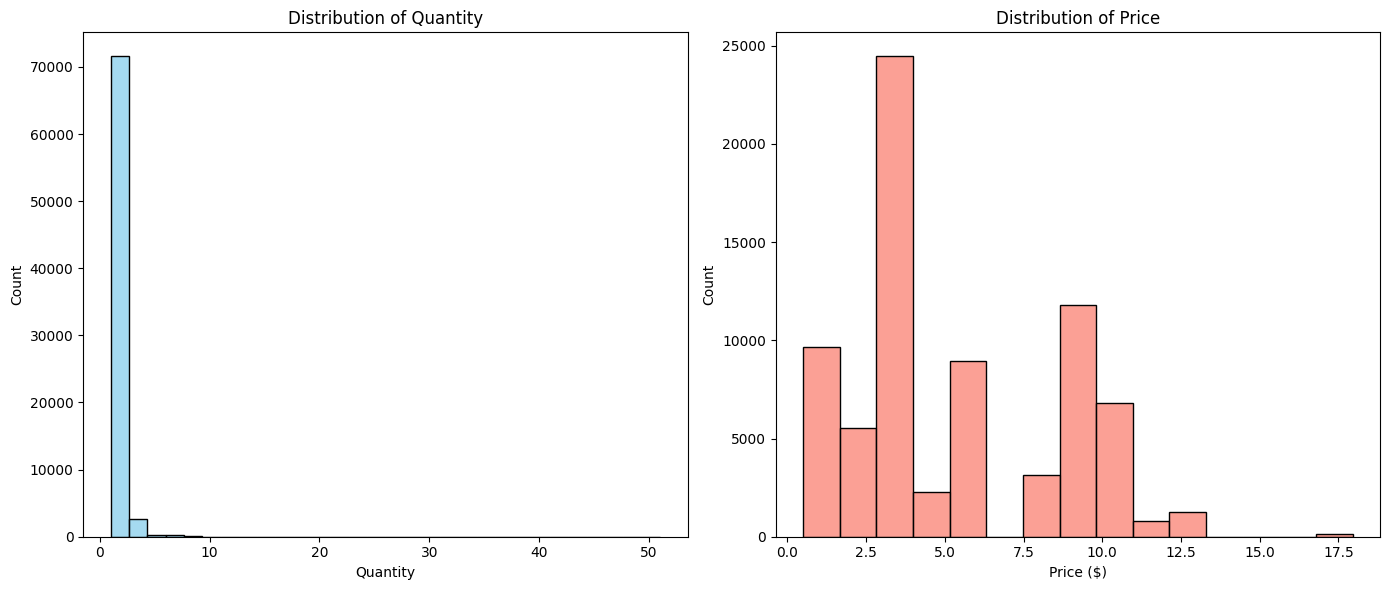

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df["quantity"], bins=30, color="skyblue")
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(df["price"], bins=15, color="salmon")
plt.title("Distribution of Price")
plt.xlabel("Price ($)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
df["item_revenue"] = df["price"] * df["quantity"]

In [ ]:
df["item_revenue"].nlargest(10)

,item_revenue
73365,660.450012
61683,223.750000
61685,223.750000
69500,199.000000
69501,199.000000
61684,179.000000
47978,119.000000
47979,119.000000
35978,79.000000
35979,79.000000


In [ ]:
df['order_revenue'] = df.groupby('order_id')["item_revenue"].sum()

In [ ]:
top_orders = df.groupby('order_id')['order_revenue'].max().nlargest(10)
top_orders

,order_revenue
order_id,
4924,1242.000000
1009,685.250000
6022,685.250000
6743,660.450012
6480,582.000000
3983,460.750000
2869,430.049988
2975,430.049988
6537,289.649994


In [ ]:
#10287
df[df['order_id'] == 10287]

,orderitem_id,datetime,product_name,price,quantity,order_id,item_revenue,order_revenue
24953,24954,2017-09-18 16:54:00,Plain Rice,2.95,20,10287,59.00,NaN
35977,35978,2017-09-18 16:54:00,Lemon Rice,3.95,10,10287,39.50,NaN
47978,47979,2017-09-18 16:54:00,Tarka Dall,5.95,20,10287,119.00,NaN
61683,61684,2017-09-18 16:54:00,Korma,8.95,25,10287,223.75,NaN
61684,61685,2017-09-18 16:54:00,Paneer Tikka Masala,8.95,20,10287,179.00,NaN
61685,61686,2017-09-18 16:54:00,Chicken Tikka Masala,8.95,25,10287,223.75,NaN
69500,69501,2017-09-18 16:54:00,Chicken Biryani,9.95,20,10287,199.00,17.700001
69501,69502,2017-09-18 16:54:00,Vegetable Biryani,9.95,20,10287,199.00,36.049999


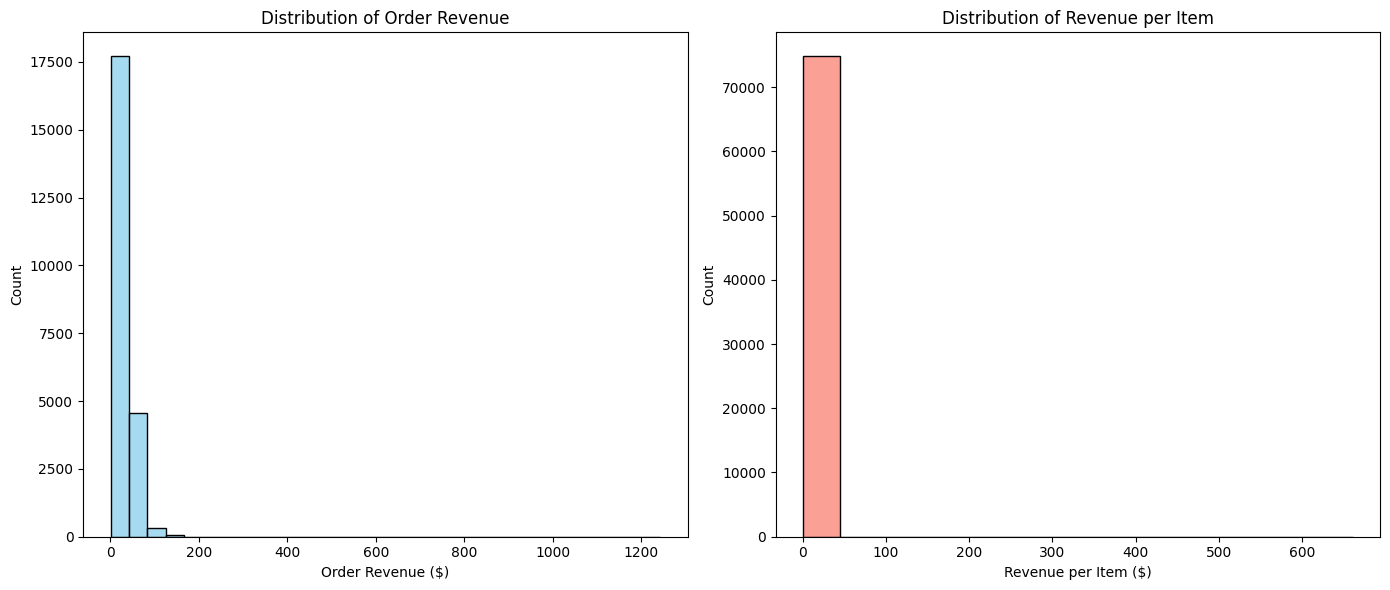

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['order_revenue'], bins=30, color='skyblue')
plt.title("Distribution of Order Revenue")
plt.xlabel("Order Revenue ($)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(df["item_revenue"], bins=15, color="salmon")
plt.title("Distribution of Revenue per Item")
plt.xlabel("Revenue per Item ($)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('clean_restaurant.csv', index=False)

#### Potential Outliers in Orders

Order ID 4924 stands out with exceptionally high total order revenue (approx. $1242), containing multiple high-quantity items.

Order ID 13379 shows a notably large single-item quantity (51 units of "King Prawn Shaslick") and high total revenue (~$660).

Other orders with high total revenue include:

| order_id | order_revenue |
|----------|---------------|
| 4924     | 1242.00       |
| 1009     | 685.25        |
| 6022     | 685.25        |
| 6743     | 660.45        |
| 6480     | 582.00        |
| 3983     | 460.75        |
| 2869     | 430.05        |
| 2975     | 430.05        |
| 6537     | 289.65        |
| 1580     | 268.50        |


**Recommendation**: These orders with unusually high revenues or quantities are potential outliers and should be further investigated before any removal or adjustment, as they may represent bulk or special orders rather than data errors.

### Key Metrics

In [ ]:
total_products = df['product_name'].nunique()
total_orders = df['order_id'].nunique()
avg_items_per_order = df.shape[0] / total_orders
min_order_date = df['datetime'].min()
max_order_date = df['datetime'].max()
avg_order_revenue = df['order_revenue'].mean()

print('Key Business Metrics:\n')
print(f"Total products: {total_products}")
print(f"Total orders: {total_orders}")
print(f"Average items per order: {avg_items_per_order:.2f}")
print(f"Order date range: {min_order_date.date()} - {max_order_date.date()}")
print(f"Average order revenue: ${avg_order_revenue:.2f}")

Key Business Metrics:

Total products: 248
Total orders: 13397
Average items per order: 5.58
Order date range: 2015-09-01 - 2019-08-03
Average order revenue: $33.81


## Data analysis and visualization

---

### Leading Products by Units Sold

In [ ]:
top_products = (df.groupby("product_name", observed=True)["quantity"]
                .sum()
                .sort_values(ascending=False)
                .head(10))

In [ ]:
norm = plt.Normalize(vmin=top_products.min(), vmax=top_products.max())
colors = plt.cm.coolwarm(norm(top_products.values))

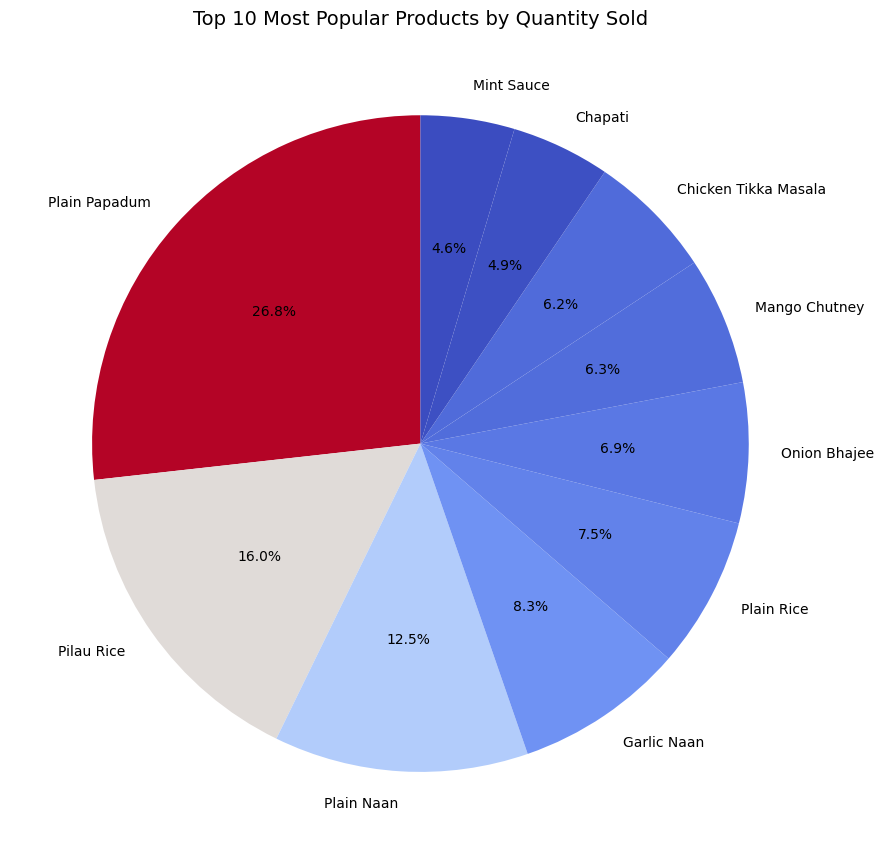

In [ ]:
plt.figure(figsize=(9, 9))
top_products.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Top 10 Most Popular Products by Quantity Sold", fontsize=14)
plt.ylabel("")  # Remove the 'quantity' label
plt.tight_layout()
plt.show()

### Top Revenue-Generating Products

In [ ]:
top_revenue_products = (df.groupby("product_name", observed=True)["item_revenue"]
                        .sum()
                        .sort_values(ascending=False)
                        .head(10))

In [ ]:
norm = plt.Normalize(vmin=top_revenue_products.min(), vmax=top_revenue_products.max())
colors = plt.cm.coolwarm(norm(top_revenue_products.values))

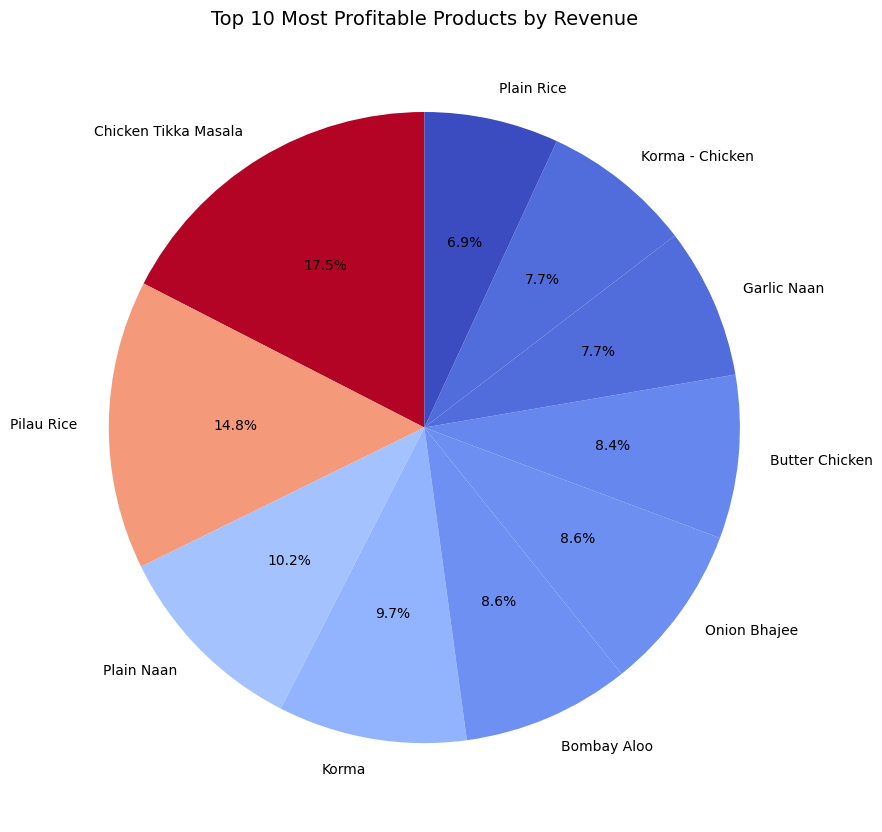

In [ ]:
plt.figure(figsize=(9, 9))
top_revenue_products.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Top 10 Most Profitable Products by Revenue", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

### Product Performance Summary


Products that generate the most revenue are typically higher-priced main dishes (like Chicken Tikka Masala), while the most frequently ordered items are often low-cost sides (like Plain Papadum). This suggests that sales volume doesn’t always align with profit contribution, and both product popularity and pricing strategy play key roles in overall restaurant performance.

### Hourly trends

In [ ]:
df["hour"] = df["datetime"].dt.hour

In [ ]:
revenue_by_hour = df.groupby(df["hour"])["item_revenue"].sum()
revenue_by_hour = revenue_by_hour.reindex(range(24), fill_value=0) #include all hours (zero-revenue as well)

In [ ]:
norm = plt.Normalize(vmin=revenue_by_hour.min(), vmax=revenue_by_hour.max())
colors = [plt.cm.coolwarm(norm(value)) for value in revenue_by_hour.values]

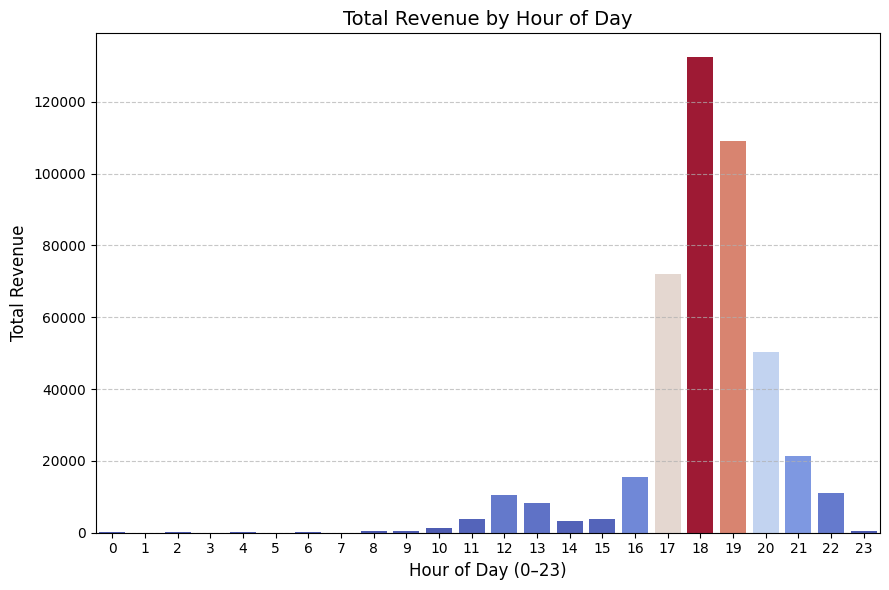

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(
    x=revenue_by_hour.index,
    y=revenue_by_hour.values,
    hue=revenue_by_hour.index,
    palette=colors,
    errorbar=None,
    legend=False
    )
plt.title("Total Revenue by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

@## Weekly Trends

---



In [ ]:
df["weekday_name"] = df["datetime"].dt.day_name().str[:3]

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
revenue_by_day = df.groupby("weekday_name")["item_revenue"].sum().reindex(days)

In [ ]:
norm = plt.Normalize(vmin=revenue_by_day.min(), vmax=revenue_by_day.max())
colors = [plt.cm.coolwarm(norm(value)) for value in revenue_by_day.values]

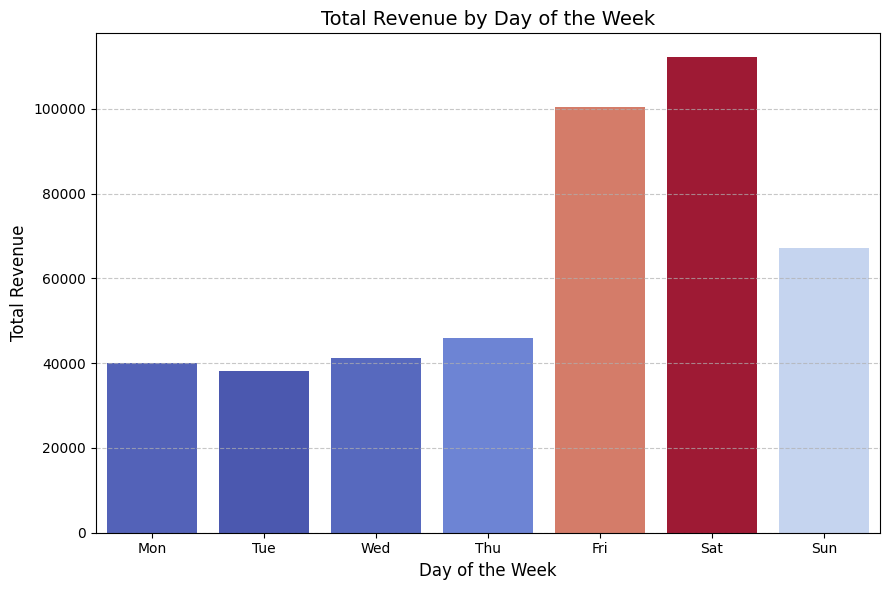

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(
    x=revenue_by_day.index,
    y=revenue_by_day.values,
    hue=revenue_by_day.index,
    palette=colors,
    errorbar=None,
    legend=False,
    )
plt.title("Total Revenue by Day of the Week", fontsize=14)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Monthly Trends

In [ ]:
df["month_name"] = df["datetime"].dt.month_name().str[:3]

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
revenue_by_month = df.groupby("month_name")["item_revenue"].sum().reindex(month_names)

In [ ]:
norm = plt.Normalize(vmin=revenue_by_month.min(), vmax=revenue_by_month.max())
colors = [plt.cm.coolwarm(norm(value)) for value in revenue_by_month.values]

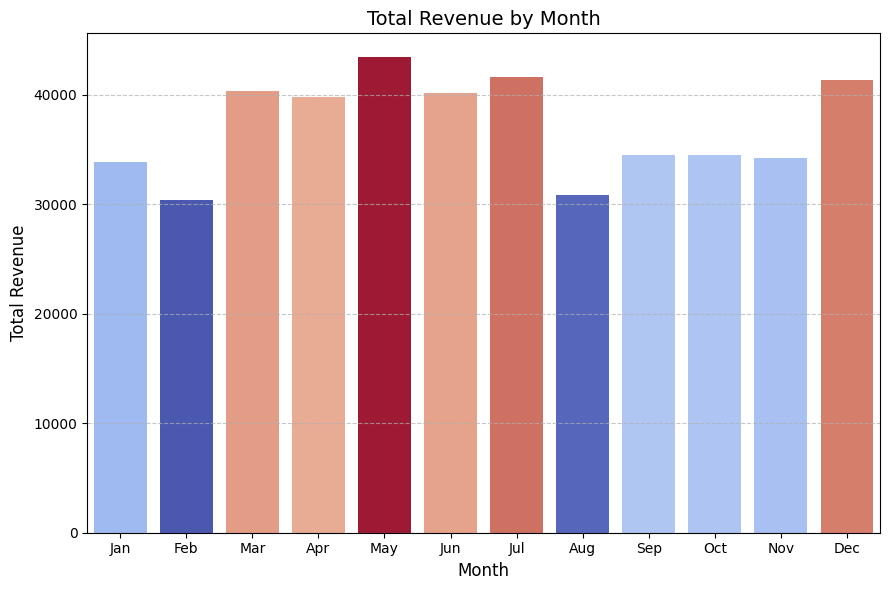

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(
    x=revenue_by_month.index,
    y=revenue_by_month.values,
    hue=revenue_by_month.index,
    palette=colors,
    errorbar=None,
    legend=False
    )
plt.title("Total Revenue by Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Long-Term Yearly Trends

In [ ]:
df["year"] = df["datetime"].dt.year

revenue_by_year = df.groupby("year")["item_revenue"].sum().sort_index()
revenue_by_year = revenue_by_year[revenue_by_year.index != 2015] # exclude empty 2015 data

In [ ]:
norm = plt.Normalize(vmin=revenue_by_year.min(), vmax=revenue_by_year.max())
colors = [plt.cm.coolwarm(norm(value)) for value in revenue_by_year.values]

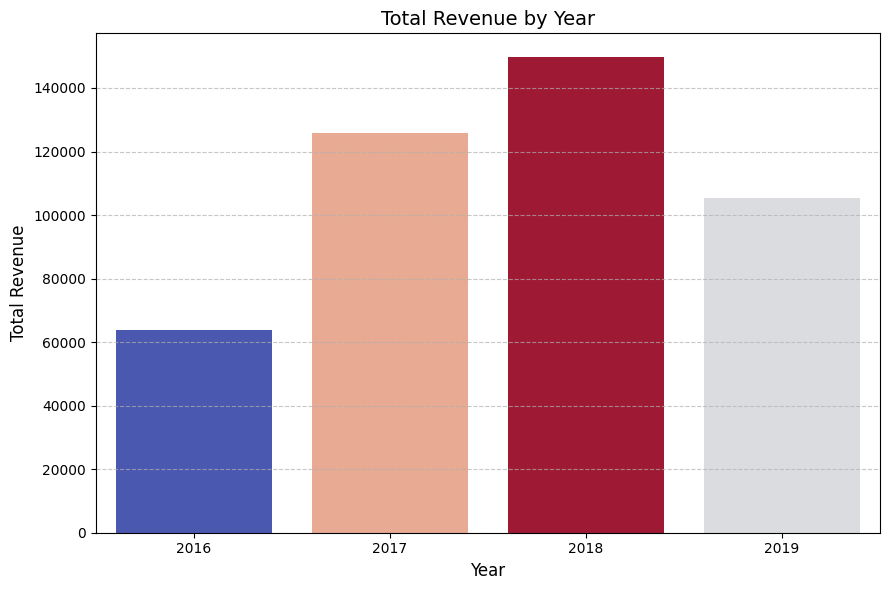

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(
    x=revenue_by_year.index.astype(str),
    y=revenue_by_year.values,
    hue=revenue_by_year.index.astype(str),
    palette=colors,
    errorbar=None
    )
plt.title("Total Revenue by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Dynamic Summary

* **By Hour**

Peak revenue hours are 17 and 20, with the highest at 18

* **By Weak**

Friday and Saturday are the top-performing days, Sunday also performs well, possibly due to weekend.

Monday through Thursday show stable revenue.

* **By Month**

Revenue is relatively consistent across months.

Monthly peaks in May–July and December suggest seasonal or holiday-driven demand, useful for planning promotions or staffing.

* **By Year**

Revenue steadily increased from 2016 to 2018.
Noticeable decline in 2019, which may indicate operational changes or external factors affecting sales.

#### The business thrives in evenings, especially on weekends.

## Combo + Wombo

---



The main idea of analyzing combo dishes is to:

* Identify commonly ordered product combinations

* Turn into combo deals to increase sales and average order value

* Analyze customer preferences more deeply

In [ ]:
grouped = df.groupby("order_id")["product_name"].apply(list)

In [ ]:
combo_counter = Counter()

for dish_list in grouped:
    unique_items = set(dish_list)  # avoid duplication
    combos = combinations(sorted(unique_items), 2)  # can be change to 3
    combo_counter.update(combos)

top_combos = combo_counter.most_common(10)
combo_df = pd.DataFrame(top_combos, columns=["Combo", "Count"])

In [ ]:
norm = plt.Normalize(vmin=combo_df["Count"].min(), vmax=combo_df["Count"].max())
colors = [plt.cm.coolwarm(norm(value)) for value in combo_df["Count"].values]

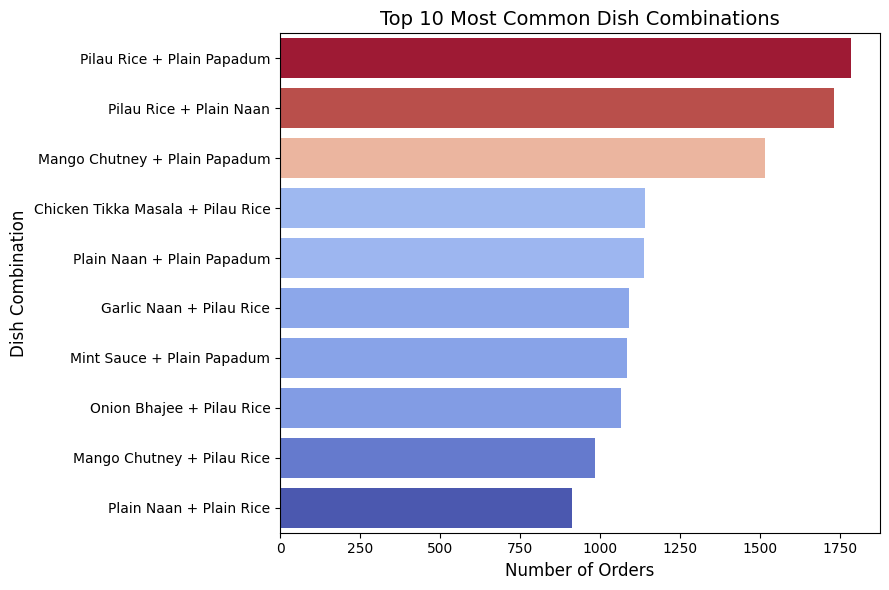

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(
    data=combo_df,
    x="Count",
    y=combo_df["Combo"].apply(lambda x: f"{x[0]} + {x[1]}"),
    hue=combo_df["Combo"].apply(lambda x: f"{x[0]} + {x[1]}"),
    palette=colors,
    legend=False
    )
plt.title("Top 10 Most Common Dish Combinations", fontsize=14)
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Dish Combination", fontsize=12)
plt.tight_layout()
plt.show()

### Combo Summary

Here's a summary of the idea regarding the analysis of dish combinations in a restaurant:

* Menu Recommendations: Use popular dish combos to create suggested sets or combos.

* Smart Pricing: Offer discounts on top combinations to boost average check (avg. 5.58 items per order).

* Effective Marketing: Base promotions on popular combos for better results; target different customer groups.

* Menu Optimization:

 Keep best-selling combos.

 Remove or cut costs on unpopular dishes.

 Use pairing rules (If a customer adds Pilau Rice, suggest Plain Naan or Papadum).

* Higher Profits:

 Boost revenue via add-on suggestions

 Discover new potential dishes.

 Build a balanced, customer-focused menu.

## Summary

---



Revenue Insights:

- High-priced main dishes (like Chicken Tikka Masala) generate the most revenue, while low-cost sides (like Plain Papadum) are the most frequently ordered.

- This shows that sales volume doesn't always correlate with profit contribution; both product popularity and pricing are crucial.

Revenue Patterns:

- By Hour: Peak revenue hours are 17:00, 18:00, and 20:00, with the highest revenue at 18:00.

- By Day: Friday and Saturday are the best-performing days, with Sunday also doing well due to the weekend.

- By Month: Revenue is stable across months, with peaks in May–July and December, likely due to seasonal or holiday demand.

- By Year: Revenue grew from 2016–2018 but declined in 2019, indicating potential operational or external challenges.

Dish Combinations Analysis:

- Menu Recommendations: Use popular dish combos to create meal suggestions.

- Smart Pricing: Offer discounts on popular combinations to increase average check size.

- Effective Marketing: Focus promotions on top combinations to target different customer groups.

- Menu Optimization: Retain best-sellers, remove unpopular dishes, and use pairing suggestions.

- Higher Profits: Suggest add-ons and discover new dish combinations to drive revenue.